In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os
from utils_data import get_numbered_binary_tags, get_layers
plt.rcParams.update({
    'font.size': 6,               # Default text size
    'axes.titlesize': 6,          # Title size for axes
    'axes.labelsize': 6,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 6,        # Overall figure title size
})
MODEL_NAME = 'gemma-2-9b'

# This file plots Figures 3,4,13, and 14

# Functions to load in normal by layer results

In [4]:
METHODS = ['logreg', 'pca', 'knn', 'xgboost', 'mlp']
METHOD_MAP = {'logreg': 'Logistic Reg.', 'pca': 'PCA', 'knn': 'KNN', 'xgboost': 'XGBoost', 'mlp': 'MLP'}
LAYERS = get_layers(MODEL_NAME)
def read_layer_normal(layer = 20):
    assert layer in LAYERS
    return pd.read_csv(f'results/baseline_probes_{MODEL_NAME}/normal_settings/layer{layer}_results.csv')

def read_layer_method_normal(layer, method):
    assert method in METHODS
    df = read_layer_normal(layer)
    return df[df['method'] == method]

# Plot the performance of each baseline method by layer (Fig. 13a)

We use this experiment to determine which layer to perform the rest of our experiments at

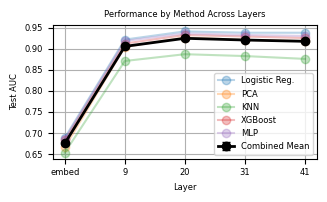

In [6]:
def plot_avg_layer():
    # Plots Fig 13a
    x_coords = np.arange(len(LAYERS))
    
    plt.figure(figsize = (3.25,2))
    
    # Store means for combined line
    all_means = []
    
    # Plot individual method lines with opacity
    for method in METHODS:
        layer_means = []
        
        for i, layer in enumerate(LAYERS):
            df = read_layer_method_normal(layer, method)
            aucs = df['test_auc'].values
            num = len(aucs)
            mean_auc = np.mean(aucs)
            layer_means.append(mean_auc)
            
        plt.plot(x_coords, layer_means, '-o', alpha=0.3, label=METHOD_MAP[method])
        all_means.append(layer_means)
    
    # Plot combined mean line with standard error
    combined_means = np.mean(all_means, axis=0)
    combined_std = np.std(all_means, axis=0)
    combined_se = 1.96 * combined_std / np.sqrt(len(METHODS) * num)
    
    plt.errorbar(x_coords, combined_means, yerr=combined_se, fmt='-o', color='black', 
                label='Combined Mean', linewidth=2, capsize=3)
    plt.xticks(x_coords, LAYERS)
    plt.xlabel('Layer')
    plt.ylabel('Test AUC')
    plt.title('Performance by Method Across Layers')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    os.makedirs('figures/normal', exist_ok=True)
    plt.savefig('figures/normal/full_baselines_by_layer_normal.pdf', dpi = 300)
    plt.savefig('figures/normal/full_baselines_by_layer_normal.png', dpi = 300)

plot_avg_layer()

# Plots the best baseline method as a function of layer (Fig. 13b)

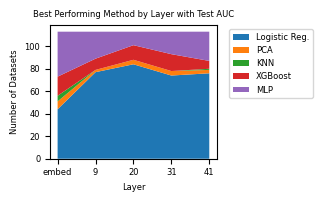

In [7]:
def plot_best_method_stack():
    # Store counts of winning methods for each layer
     # Plots Fig 13b
    layer_method_counts = {layer: {method: 0 for method in METHODS} for layer in LAYERS}
    
    # For each layer, find winning method per dataset
    for layer in LAYERS:
        # Get all methods' results for this layer
        layer_df = read_layer_normal(layer)
        
        # Group by dataset and get row with highest test_auc for each
        best_methods = layer_df.loc[layer_df.groupby('dataset')['test_auc'].idxmax()]
        
        # Count occurrences of each method
        method_counts = best_methods['method'].value_counts()
        for method in method_counts.index:
            layer_method_counts[layer][method] = method_counts[method]
    
    # Convert counts to arrays for stacking
    method_arrays = []
    for method in METHODS:
        method_counts = [layer_method_counts[layer][method] for layer in LAYERS]
        method_arrays.append(method_counts)
    
    # Create stackplot
    plt.figure(figsize=(3.25, 2))
    x = np.arange(len(LAYERS))
    plt.stackplot(x, method_arrays, labels=[METHOD_MAP[method] for method in METHODS])
    plt.xticks(x, LAYERS)
    plt.xlabel('Layer')
    plt.ylabel('Number of Datasets')
    plt.title('Best Performing Method by Layer with Test AUC')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('figures/normal/best_method_by_layer.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('figures/normal/best_method_by_layer.png', dpi=300, bbox_inches='tight')

plot_best_method_stack()

# Plot SAE

In [10]:
def read_all_sae(layer = 20, reg = 'l1'):
    df = pd.read_csv(f'results/sae_probes_{MODEL_NAME}/normal_setting/all_metrics.csv')
    df = df[df['layer'] ==  layer]
    #print(df.columns)
    df = df[df['reg_type'] == reg]
    return df

def read_useful_sae():
    df = pd.read_csv(f'results/sae_probes_{MODEL_NAME}/normal_setting/l1_layer20_max_l0.csv')
    df = df[df['sae_width'].isin(['16k', '131k', '1m'])]
    # Get the maximum k value for each width
    # Filter to only keep rows where k is 32 or 128
    df = df[df['k'].isin([16, 128])]
    df['method'] = 'sae_' + df['sae_width'] + '_k' + df['k'].astype(str) + '_' + df['sae_l0'].astype(str) + 'l0'
    df = df[['test_f1', 'test_acc', 'test_auc', 'val_auc', 'dataset', 'method']]
    return df


# Plot the performance of SAE probes at layer 20 as a function of width and L0
Fig. 14a

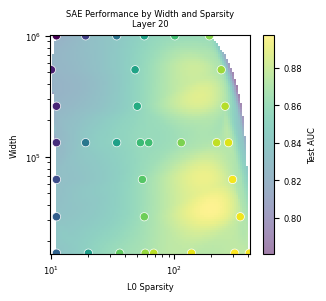

In [8]:
def plot_pareto_l0_width(layer=20):
    saes = read_all_sae(layer=layer)
    saes['sae_width'] = saes['sae_width'].str.replace('k', '000').str.replace('m', '000000').astype(int)
    # Group by width and l0, calculate mean test_auc
    avg_aucs = saes.groupby(['sae_width', 'sae_l0'])['test_auc'].mean().reset_index()
    
    # Create grid
    grid_l0 = np.geomspace(avg_aucs['sae_l0'].min(), avg_aucs['sae_l0'].max(), 100)
    grid_width = np.geomspace(avg_aucs['sae_width'].min(), avg_aucs['sae_width'].max(), 100)
    l0, width = np.meshgrid(grid_l0, grid_width)

    # Interpolate data
    points = avg_aucs[['sae_l0', 'sae_width']]
    values = avg_aucs['test_auc']
    test_auc_grid = griddata(points, values, (l0, width), method='cubic')
    
    plt.figure(figsize=(3.25, 3))
    # Plot interpolated heatmap with transparency
    heatmap = plt.pcolormesh(l0, width, test_auc_grid, shading='auto', cmap='viridis', alpha=0.5)
    plt.colorbar(heatmap, label='Test AUC')
    
    # Plot original data points
    plt.scatter(avg_aucs['sae_l0'], avg_aucs['sae_width'], c=avg_aucs['test_auc'], 
               cmap='viridis', edgecolor='white', linewidth=0.5)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('L0 Sparsity')
    plt.ylabel('Width')
    plt.title(f'SAE Performance by Width and Sparsity\nLayer {layer}')
    
    plt.tight_layout()
    plt.savefig(f'figures/normal/sae_pareto_l0_width_layer{layer}.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'figures/normal/sae_pareto_l0_width_layer{layer}.png', dpi=300, bbox_inches='tight')

plot_pareto_l0_width()

# Plots the test AUC of SAEs as a function of width. Smaller widths are better
Fig. 14b

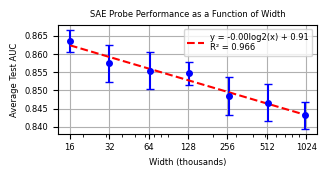

In [11]:
def plot_width(layer=20):
    df = read_all_sae(layer=layer)
    df['sae_width'] = df['sae_width'].str.replace('k', '000').str.replace('m', '000000').astype(int)
    
    # Calculate mean, std and confidence intervals for each width
    width_stats = df.groupby('sae_width').agg({
        'test_auc': ['mean', 'std', 'count']
    }).reset_index()
    width_stats.columns = ['sae_width', 'mean', 'std', 'count']
    width_stats['ci_95'] = 1.96 * width_stats['std'] / np.sqrt(width_stats['count'])
    
    # Create figure
    plt.figure(figsize=(3.25, 1.75))
    
    # Plot scatter with error bars
    plt.errorbar(width_stats['sae_width']/1000, width_stats['mean'], 
                yerr=width_stats['ci_95'],
                fmt='o', color='b', capsize=3, markersize=4)
    
    # Fit line in log space and calculate R^2
    x = np.log2(width_stats['sae_width'])
    y = width_stats['mean']
    z = np.polyfit(x, y, 1)
    p = lambda x_lin: z[0] * np.log2(x_lin) + z[1]
    r2 = np.corrcoef(x, y)[0,1]**2
    
    # Plot best fit line
    x_line = width_stats['sae_width']
    plt.semilogx(x_line/1000, p(x_line), 'r--', 
            label=f'y = {z[0]:.2f}log2(x) + {z[1]:.2f}\nR² = {r2:.3f}')
    
    plt.xlabel('Width (thousands)')
    plt.ylabel('Average Test AUC')
    plt.title('SAE Probe Performance as a Function of Width')
    plt.grid(True)
    plt.legend()
    
    # Set x-axis ticks to powers of 2
    plt.xticks([2**i for i in range(4,11)], [str(2**i) for i in range(4,11)])
    
    # Save plots
    savepath = 'figures/normal/sae_width_auc'
    plt.tight_layout()
    plt.savefig(f'{savepath}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{savepath}.pdf', dpi=300, bbox_inches='tight')

plot_width()


# Plot the SAE probe performance as a function of L0 and k
Uses a fixed width, the smallest one. Fig. 3

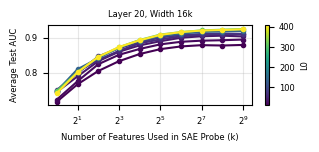

In [12]:
def plot_l0_k_16k(layer=20):
    df = read_all_sae(layer=layer)
    # Get unique combinations of width and layer
    unique_widths = ['16k']  # Only plot 16k
    unique_layers = [20]

    # Create subplot grid
    n_rows = len(unique_layers)
    n_cols = len(unique_widths)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.25, 1.5), sharex=True, sharey=True)
    plt.subplots_adjust(wspace = 0)

    # Plot for each combination
    for i, layer in enumerate(unique_layers):
        for j, width in enumerate(unique_widths):
            ax = axes if n_rows == 1 and n_cols == 1 else axes[j]
            
            # Filter data for this width/layer combo
            mask = (df["sae_width"] == width) & (df["layer"] == layer)
            df_subset = df[mask]
            
            if len(df_subset) > 0:  # Only plot if we have data for this combo
                # Sort SAE IDs by l0 value
                sae_ids_sorted = sorted(df_subset["sae_id"].unique(), 
                                    key=lambda x: df_subset[df_subset["sae_id"] == x]["sae_l0"].iloc[0])
                
                # Create colormap
                norm = plt.Normalize(vmin=min(df_subset["sae_l0"]), vmax=max(df_subset["sae_l0"]))
                cmap = plt.cm.viridis
                sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
                
                for sae_id in sae_ids_sorted:
                    df_chosen = df_subset[df_subset["sae_id"] == sae_id]
                    l0_value = df_chosen["sae_l0"].iloc[0]
                    
                    # Calculate mean and confidence intervals for each k
                    stats = df_chosen.groupby('k')['test_auc'].agg(['mean', 'std', 'count'])
                    stats['ci_95'] = 1.96 * stats['std'] / np.sqrt(stats['count'])
                    
                    # Plot mean line with powers of 2 x axis ticks
                    k_values = stats.index
                    ax.plot(k_values, stats['mean'], '-o', 
                            color=cmap(norm(l0_value)), markersize=3)
                    
                    # # Add confidence interval shading
                    # ax.fill_between(stats.index, 
                    #               stats['mean'] - stats['ci_95'],
                    #               stats['mean'] + stats['ci_95'],
                    #               color=color, alpha=0.2)
            
            ax.grid(True, alpha = 0.3)
            ax.set_title(f'Layer {layer}, Width {width}')
            ax.set_xlabel('Number of Features Used in SAE Probe (k)', fontsize=6)
            ax.set_ylabel('Average Test AUC', fontsize=6)
            ax.tick_params(axis='both', which='major', labelsize=6)
            
            # Set x-axis to powers of 2
            ax.set_xscale('log', base=2)
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: rf'$2^{int(np.log2(x))}$'))
            
            # Add colorbar
            cbar = plt.colorbar(sm, ax=ax)
            cbar.set_label('L0')
            cbar.ax.tick_params()

    savepath = 'figures/normal/sae_l0_k_normal_pareto_16k'
    plt.tight_layout()
    plt.savefig(f'{savepath}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{savepath}.pdf', dpi=300, bbox_inches='tight')

plot_l0_k_16k()

# Compare with SAE

In [14]:
def arrow_quiver(sae = False):
    # does the quiver of arrows approach. we first
    # use sae = False to see how baselines do alone
    # and then see how our approach does when
    # SAEs are added back into the mix
    df = read_layer_normal()
    if sae:
        saedf = read_useful_sae()
        # Combine baseline and SAE dataframes if SAE data provided
        df = pd.concat([df, saedf], ignore_index=True)
    best_methods = df.loc[df.groupby('dataset')['val_auc'].idxmax()]
    # Calculate percentage of methods containing 'sae'
    sae_methods = best_methods['method'].str.contains('sae')
    sae_percentage = (sae_methods.sum() / len(best_methods)) * 100
    print(f"Percentage of best methods that are SAE: {sae_percentage:.1f}%")
    print(f'Num SAE: {sae_methods.sum()}')
    return best_methods.reset_index(drop=True)


# Plot normal improvement
Fig. 4

Percentage of best methods that are SAE: 0.0%
Num SAE: 0
Percentage of best methods that are SAE: 12.4%
Num SAE: 14


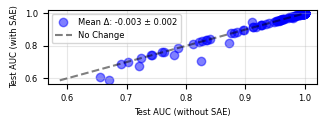

In [15]:
def plot_improvement_normal():
    nosae = arrow_quiver(sae = False)
    sae = arrow_quiver(sae = True)
    
    # Calculate mean and standard error of difference
    diff = sae['test_auc'] - nosae['test_auc']
    mean_diff = np.mean(diff)
    se_diff = np.std(diff) / np.sqrt(len(diff))
    
    plt.figure(figsize=(3.25,1.25))
    plt.scatter(nosae['test_auc'], sae['test_auc'], alpha=0.5, color = 'b',
               label=f'Mean Δ: {mean_diff:.3f} ± {se_diff:.3f}')
    
    # Add diagonal line only spanning the data range
    min_val = min(nosae['test_auc'].min(), sae['test_auc'].min())
    max_val = max(nosae['test_auc'].max(), sae['test_auc'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label = 'No Change')
    
    # Annotate points with largest absolute differences
    plt.xlabel('Test AUC (without SAE)')
    plt.ylabel('Test AUC (with SAE)')
    
    plt.legend()
    plt.grid(alpha = 0.3)
    plt.tight_layout()
    plt.savefig('figures/normal/sae_vs_nosae_normal_comparison.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('figures/normal/sae_vs_nosae_normal_comparison.png', dpi=300, bbox_inches='tight')

plot_improvement_normal()